In [1]:
using CSV, DataFrames, Plots

In [2]:
cd(@__DIR__)

isfile("iris.data") ||
    download("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", 
    "iris.data")

true

In [3]:
header = [
    :sepal_length,
    :sepal_width,
    :petal_length,
    :petal_width,
    :species
]

iris = CSV.read("iris.data", header=header, limit=150)

disallowmissing!(iris)

iris[1:5, :]

,sepal_length,sepal_width,petal_length,petal_width,species
,Float64,Float64,Float64,Float64,String
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
using MLBase: labelmap, labelencode


# https://mlbasejl.readthedocs.io/en/latest/datapre.html#data-repetition
lm = labelmap(iris[:species])

iris[:labels] = labelencode(lm, iris[:species])

iris[1:5, :]

,sepal_length,sepal_width,petal_length,petal_width,species,labels
,Float64,Float64,Float64,Float64,String,Int64
1,5.1,3.5,1.4,0.2,Iris-setosa,1
2,4.9,3.0,1.4,0.2,Iris-setosa,1
3,4.7,3.2,1.3,0.2,Iris-setosa,1
4,4.6,3.1,1.5,0.2,Iris-setosa,1
5,5.0,3.6,1.4,0.2,Iris-setosa,1


In [5]:
X_raw = Matrix{Float32}(iris[1:end, 1:4])'
y_raw = Array{Int8}(iris[:labels]);


In [6]:
using Statistics: mean, std

In [7]:
hcat(mean(X_raw, dims=2), std(X_raw,  dims=2))

4×2 Array{Float32,2}:
 5.84333  0.828066
 3.054    0.433594
 3.75867  1.76442 
 1.19867  0.763161

In [8]:
# Normlize X_raw, an m features x n examples matrix
X_raw_normed = (X_raw .- mean(X_raw, dims = 2)) ./ std(X_raw, dims = 2)

hcat(mean(X_raw_normed, dims=2), std(X_raw_normed,  dims=2))

4×2 Array{Float32,2}:
 -1.74463e-6  1.0
  2.57939e-7  1.0
  3.69549e-8  1.0
 -5.0505e-7   1.0

In [9]:
using MLDataUtils: shuffleobs, splitobs

In [10]:
Xs, ys = shuffleobs((X_raw_normed, y_raw))

ys[1:10]

10-element Array{Int8,1}:
 2
 3
 3
 1
 2
 1
 3
 2
 1
 3

In [13]:
(X_train, y_train), (X_test, y_test) = splitobs((Xs, ys); at=0.67)

@show size(X_train)
@show size(X_test);

size(X_train) = (4, 100)
size(X_test) = (4, 50)


In [14]:
using Flux
using Flux.Tracker
using Flux: onehotbatch, onecold, crossentropy, data

loaded


In [15]:
y_train_onehot = onehotbatch(y_train, levels(y_train))
y_test_onehot  = onehotbatch(y_test,  levels(y_test))




3×50 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 false   true  false   true   true  …  false  false   true  false  false
 false  false  false  false  false      true   true  false  false  false
  true  false   true  false  false     false  false  false   true   true

In [16]:
# Logistic Regression Model

# 4 features input.
# 3 classes output
model = Chain(
  Dense(4, 3),
  softmax
) |> gpu


Chain(Dense(4, 3), NNlib.softmax)

In [17]:
loss(x, y) = crossentropy(model(x), y)

loss (generic function with 1 method)

In [18]:
accuracy(x, y) = mean(onecold(model(x)) .== onecold(y))

accuracy (generic function with 1 method)

In [19]:
learning_rate = 0.1

opt = SGD(params(model), learning_rate)


#43 (generic function with 1 method)

In [20]:
losses = []
train_accuracies = []
test_accuracies  = []


0-element Array{Any,1}

In [21]:
accuracy(X_train, y_train_onehot)

0.01

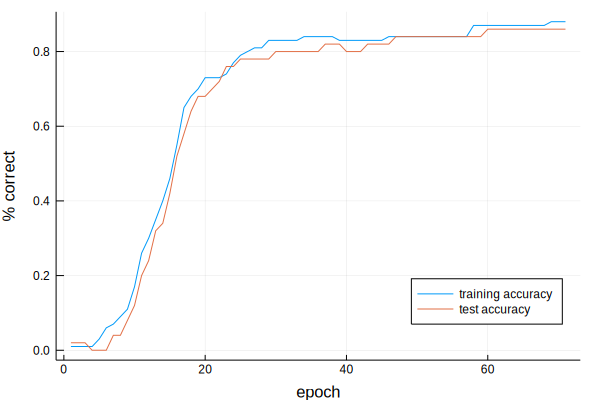

In [29]:
for epoch in 1:10
     push!(losses, data(loss(X_train, y_train_onehot)))
     push!(train_accuracies, accuracy(X_train, y_train_onehot))
     push!(test_accuracies, accuracy(X_test, y_test_onehot))

    Flux.train!(loss, [(X_train, y_train_onehot)], opt)
end


plot(train_accuracies, label="training accuracy", legend=:bottomright, xlabel="epoch", ylabel="% correct")
plot!(test_accuracies, label="test accuracy", legend=:bottomright)